In [1]:
import pandas as pd
import numpy as np
import sys, os
import seaborn as sns
from scipy.stats import hypergeom
from sklearn.metrics import normalized_mutual_info_score
from topicpy.hsbmpy import get_max_available_L, get_scores, add_score_lines
import matplotlib.pyplot as plt
import multiprocessing as mp
from time import time
import logging
log = logging.getLogger()

In [2]:
population=pd.read_csv("https://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel()

In [3]:
df_files = pd.read_csv("random11/files.dat", index_col=0)

In [5]:
experiments = ["random00", "random11","random22","random33","random44","random55","random66","random77","random88","random99"]
genes = []
for directory in experiments:
    genes.append(pd.read_csv(f"{directory}/mainTable.csv", index_col=0).index)

In [6]:
def get_pval(setA, setB):
    x = setA.isin(setB).sum() # number of successes
    M = len(population) # pop size
    k = len(setB) # successes in pop
    N = len(setA) # sample size
    pval = hypergeom.sf(x-1, M, k, N)
    return pval
#-np.log10(get_pval(setA, setB)+1)

In [7]:
overlaps = list(map(lambda setA: list(map(lambda setB: setA.isin(setB).sum()/float(len(setA)), genes)), genes))

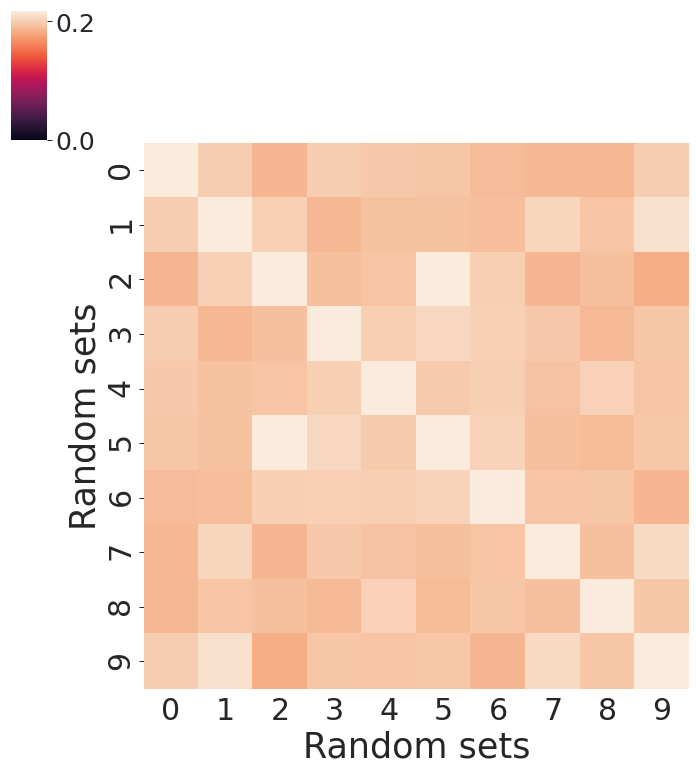

In [35]:
cm = sns.clustermap(overlaps, 
               row_cluster=False,
               col_cluster=False, 
               vmin=0,
                   vmax=max(list(map(lambda x: max(filter(lambda xi: xi<1,x)), overlaps)))
)

ax = cm.ax_heatmap
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Random sets", fontsize=35)
ax.set_xlabel("Random sets", fontsize=35)
ax.tick_params(labelsize=30)

bax = cm.ax_cbar
bax.tick_params(labelsize=25)
cm.savefig("random_overlap.pdf")

In [20]:
algorithm = "topsbm"

In [32]:
def get_scores_mp(directory):
    return directory, get_scores(directory, ["SMTS"], algorithm=algorithm)["SMTS"]

def get_scores_clbck(packed_score):
    global scores
    scores[packed_score[0]]=packed_score[1]

In [33]:
scores = {}
        
start = time()
    
pool = mp.Pool(12)

work = [pool.apply_async(get_scores_mp, args=([directory]), callback=get_scores_clbck, error_callback=lambda err:print(err)) for directory in experiments]

pool.close()
pool.join()

print(time()-start)

6.654381036758423


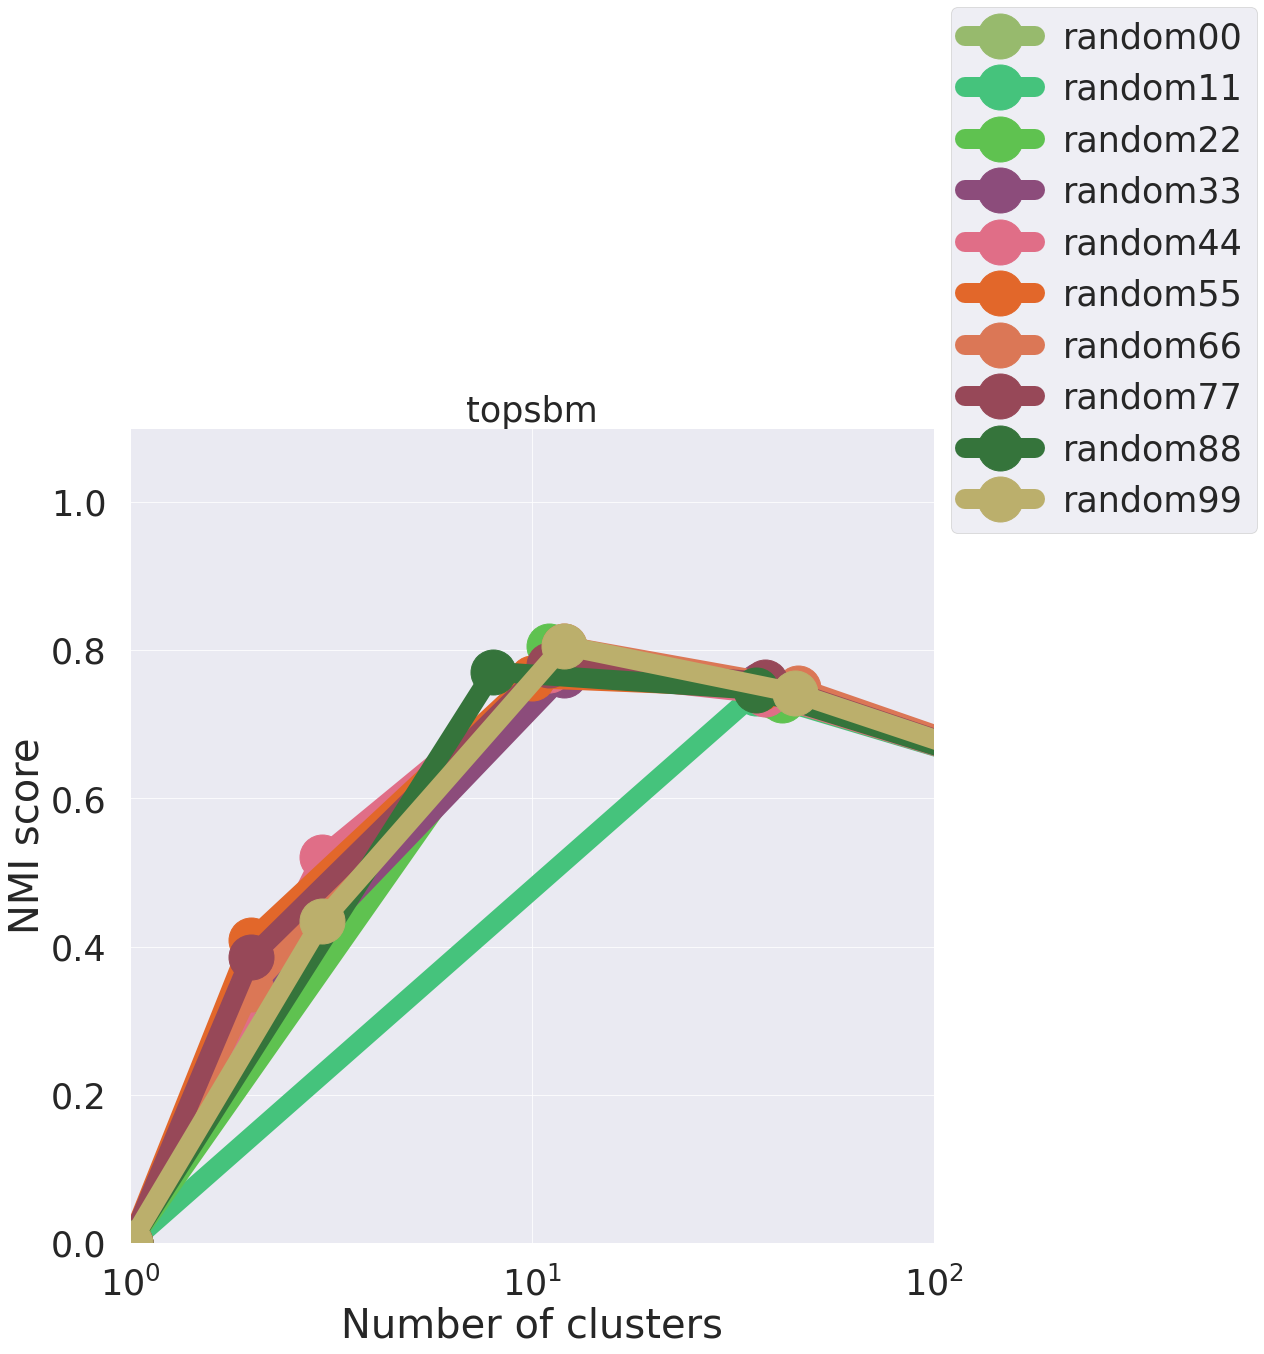

In [34]:
fig, ax = plt.subplots(figsize=(18,15))
add_score_lines(ax, scores, labels = experiments)
ax.set_xlim(1,100)
ax.set_title(algorithm, fontsize=35)
fig.savefig(f"scores_{algorithm}.pdf")

In [25]:
files = pd.DataFrame(index=df_files.reindex(index=pd.read_csv(f"random11/{algorithm}/{algorithm}_level_1_topic-dist.csv")["doc"]).index, columns = experiments)

def get_exp_labels(experiment):
    global files
    df_clusters = pd.read_csv(f"{experiment}/topsbm/topsbm_level_1_clusters.csv")
    exp_data = []
    for file in files.index:
        exp_data.append(df_clusters.columns[df_clusters[df_clusters==file].any(0)].values[0].split(" ")[1])
    return experiment, exp_data

def exb_clbck(exp_data):
    global files
    files[exp_data[0]]=exp_data[1]

In [26]:
scores = {}
        
start = time()
    
pool = mp.Pool(12)

work = [pool.apply_async(get_exp_labels, args=([directory]), callback=exb_clbck, error_callback=lambda err:print(err)) for directory in experiments]

pool.close()
pool.join()

print(time()-start)

7.21515417098999


In [27]:
partitions = files.transpose().values

In [28]:
partition_overlap = list(map(lambda partitionA: list(map(lambda partitionB: normalized_mutual_info_score(partitionA, partitionB), partitions)), partitions))

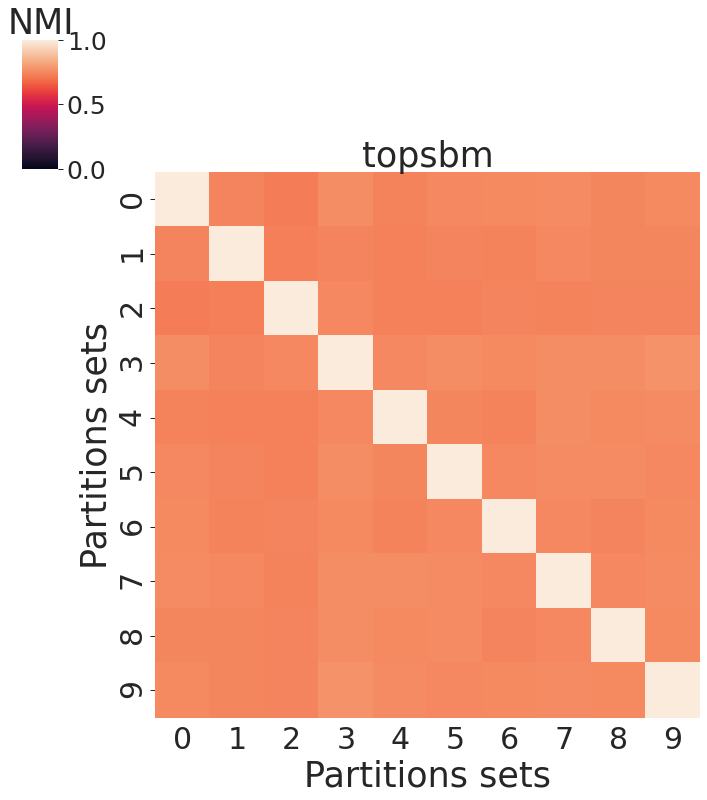

In [30]:
hm = sns.clustermap(
    partition_overlap, 
    row_cluster=False,
    col_cluster=False,
    vmin=0.0
)

ax = hm.ax_heatmap
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Partitions sets", fontsize=35)
ax.set_xlabel("Partitions sets", fontsize=35)
ax.tick_params(labelsize=30)

ax.set_title(algorithm, fontsize=35)

bax = hm.ax_cbar
bax.tick_params(labelsize=25)
bax.set_title("NMI", fontsize=35)

plt.show()
hm.savefig(f"heatmap_clusters_{algorithm}.pdf")